In [62]:
#G01276965
#importing all libraries
import findspark
findspark.init()
import sparknlp
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, when, concat
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
import re
import sys
import autocorrect
from pyspark.sql.types import StringType, IntegerType
from autocorrect import Speller
from collections import Counter

from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer
from sparknlp.annotator import Normalizer
from sparknlp.annotator import LemmatizerModel
from sparknlp.annotator import StopWordsCleaner
from sparknlp.annotator import NGramGenerator
from sparknlp.annotator import PerceptronModel
from sparknlp.base import Finisher
from pyspark.ml import Pipeline
from textblob import TextBlob

from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF

from pyspark.ml.clustering import LDA
from pyspark.sql import types as T
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import StopWordsRemover,Tokenizer, RegexTokenizer, CountVectorizer, IDF
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf, col, size, explode, regexp_replace, trim, lower, lit
from pyspark.sql.types import ArrayType, StringType, DoubleType, IntegerType, LongType
from pyspark.ml.clustering import LDA
import pyLDAvis


In [63]:
#starting spark
spark = sparknlp.start()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

In [64]:
#loading the dataset
data = spark.read.csv("hashtag_joebiden.csv", header = True)
data.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- retweet_count: string (nullable = true)
 |-- source: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_join_date: string (nullable = true)
 |-- user_followers_count: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- collected_at: string (nullable = true)



In [65]:
#printing data here
data.show()

+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+--------------------+-------------+--------+---------+--------------------+----------+--------------------+
|          created_at|            tweet_id|               tweet|               likes|  retweet_count|              source|             user_id|           user_name|    user_screen_name|    user_description|      user_join_date|user_followers_count|       user_location|    lat|                long|         city| country|continent|               state|state_code|        collected_at|
+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---

In [66]:
#selecting only the tweet column which has data
data = data.select('tweet')
#limiting data (optional to run the code faster for debugging)
#data = data.limit(1000)
#droping null values
data = data.na.drop()
temp=data
data.show()

+--------------------+
|               tweet|
+--------------------+
|#Elecciones2020 |...|
|                 0.0|
|              1860.0|
|#HunterBiden #Hun...|
|@IslandGirlPRV @B...|
|                 0.0|
|@chrislongview Wa...|
|#censorship #Hunt...|
| 2018-08-24 01:49:01|
|"""IS THIS WRONG?...|
|                 0.0|
|In 2020, #NYPost ...|
|                 0.0|
|►► Tell Politicia...|
|#Biden https://t....|
|Proof  Bidens are...|
|                 1.0|
|Now Open! Create ...|
|                 0.0|
|FBI Allegedly Obt...|
+--------------------+
only showing top 20 rows



In [67]:
#creating a function to clean all data
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@â'
def clean_tweets (tweet):
    tweet = str(tweet)
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    tweet = re.sub(r'http\S+', '', tweet) 
    tweet = re.sub(r'bit.ly/\S+', '', tweet) 
    tweet = tweet.strip('[link]')
    tweet = tweet.lower() # lower case
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet) 
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) 
    tweet = re.sub('\s+', ' ', tweet) 
    tweet = re.sub('([0-9]+)', '', tweet) 
    return tweet

<>:5: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
C:\Users\Darkwolf\AppData\Local\Temp\ipykernel_28680\1057082520.py:5: DeprecationWarning: invalid escape sequence \s
  tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
C:\Users\Darkwolf\AppData\Local\Temp\ipykernel_28680\1057082520.py:13: DeprecationWarning: invalid escape sequence \s
  tweet = re.sub('\s+', ' ', tweet)


In [68]:
#used sql udf to clean all data
udfclean = udf(clean_tweets,StringType())
data = data.withColumn("tweetClean",udfclean(data.tweet))
replaceCols=["tweet","tweetClean"]
data = data.select([when(col(c)==" ",None).otherwise(col(c)).alias(c) for c in replaceCols])
data = data.na.drop(subset=["tweetClean"])
data.show()

+--------------------+--------------------+
|               tweet|          tweetClean|
+--------------------+--------------------+
|#Elecciones2020 |...|elecciones en flo...|
|#HunterBiden #Hun...|hunterbiden hunte...|
|@IslandGirlPRV @B...| this is how bide...|
|@chrislongview Wa...| watching and set...|
|#censorship #Hunt...|censorship hunter...|
| 2018-08-24 01:49:01|                    |
|"""IS THIS WRONG?...| is this wrong co...|
|In 2020, #NYPost ...|in  nypost is bei...|
|►► Tell Politicia...|►► tell politicia...|
|#Biden https://t....|              biden |
|Proof  Bidens are...|proof bidens are ...|
|Now Open! Create ...|now open create a...|
|FBI Allegedly Obt...|fbi allegedly obt...|
|#JoeBiden was the...|joebiden was the ...|
|Y’all Just Lockin...|y’all just lockin...|
|@tedcruz @cc125 #...| trump blm obama ...|
|#IceCube isn’t a ...|icecube isn’t a s...|
|BREAKING — Twitte...|breaking — twitte...|
|"Comments on this...| comments on this...|
|https://t.co/khrZ...| here is j

In [69]:
#functions to get the sentiment and polarity of tweet
def Polarity(tweet):
    return TextBlob(tweet).sentiment.polarity

# Create function to obtain Sentiment category
def Sentiment(polarity):
    if polarity < 0:
        return 0
    elif polarity == 0:
        return 0
    else:
        return 1

In [70]:
#using udf to call Polarity and Sentiment functions and added them as column
udfPol = udf(Polarity,StringType())
udfSent = udf(Sentiment,IntegerType())
df = data.select('tweetClean')
df = df.withColumn('Polarity',udfPol(df.tweetClean))
df = df.withColumn('Sentiment',udfSent(df.Polarity))
df.show()

+--------------------+-------------------+---------+
|          tweetClean|           Polarity|Sentiment|
+--------------------+-------------------+---------+
|elecciones en flo...|                0.0|        0|
|hunterbiden hunte...|                0.0|        0|
| this is how bide...|                0.0|        0|
| watching and set...|                0.0|        0|
|censorship hunter...|                0.0|        0|
|                    |                0.0|        0|
| is this wrong co...|0.13333333333333333|        1|
|in  nypost is bei...|                0.0|        0|
|►► tell politicia...|                0.4|        1|
|              biden |                0.0|        0|
|proof bidens are ...|                0.0|        0|
|now open create a...|0.38333333333333336|        1|
|fbi allegedly obt...|               -0.1|        0|
|joebiden was the ...|                0.0|        0|
|y’all just lockin...|               -0.6|        0|
| trump blm obama ...|               -0.2|    

In [71]:
#setting up pre-processing functions
lemmatizer = WordNetLemmatizer()
my_stopwords = stopwords.words('english')
word_rooter = PorterStemmer().stem

In [72]:
#doing pre-processing of data to convert it to single words seperated by columns
documentAssembler = DocumentAssembler().setInputCol('tweetClean').setOutputCol('document')
tokenizer = sparknlp.annotator.Tokenizer().setInputCols(['document']).setOutputCol('tokenizer')
normalizer = sparknlp.annotator.Normalizer().setInputCols(['tokenizer']).setOutputCol('normalizer').setLowercase(True)
lemmatizer = sparknlp.annotator.LemmatizerModel.pretrained().setInputCols(['normalizer']).setOutputCol('lemmatizer')
stopwords_cleaner = sparknlp.annotator.StopWordsCleaner().setInputCols(['lemmatizer']).setOutputCol('stopword').setStopWords(my_stopwords)
ngrammer = sparknlp.annotator.NGramGenerator().setInputCols(['lemmatizer']).setOutputCol('NGram').setN(3).setEnableCumulative(True).setDelimiter('_')
pos_tagger = sparknlp.annotator.PerceptronModel.pretrained('pos_anc').setInputCols(['document', 'lemmatizer']).setOutputCol('pos')
finisher = sparknlp.base.Finisher().setInputCols(['stopword', 'NGram','pos'])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]


In [73]:
#pipeline for pre-processing
pipeline = Pipeline().setStages([documentAssembler,tokenizer,normalizer,lemmatizer,stopwords_cleaner,pos_tagger,ngrammer,finisher])
ProcessedTweets = pipeline.fit(data).transform(data)
ProcessedTweets = ProcessedTweets.withColumn('final',concat(col('finished_stopword'), col('finished_NGram')))
ProcessedTweets.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               tweet|          tweetClean|   finished_stopword|      finished_NGram|        finished_pos|               final|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|#Elecciones2020 |...|elecciones en flo...|[elecciones, en, ...|[elecciones, en, ...|[NNS, VBP, NNP, N...|[elecciones, en, ...|
|#HunterBiden #Hun...|hunterbiden hunte...|[hunterbiden, hun...|[hunterbiden, hun...|   [NN, NNS, NN, NN]|[hunterbiden, hun...|
|@IslandGirlPRV @B...| this is how bide...|[biden, make, tru...|[this, be, how, b...|[DT, VB, WRB, JJ,...|[biden, make, tru...|
|@chrislongview Wa...| watching and set...|[watch, set, dvr,...|[watch, and, set,...|[NN, CC, VBN, NN,...|[watch, set, dvr,...|
|#censorship #Hunt...|censorship hunter...|[censorship, hunt...|[censorship, hunt...|[NN, NN, NN, NNS,..

In [74]:
#creating a count vectorizer and IDF for LDA
cv = CountVectorizer(inputCol='final',outputCol='features')
cvmodel = cv.fit(ProcessedTweets)
cvresult = cvmodel.transform(ProcessedTweets)
idf = IDF(inputCol='features', outputCol='newfeatures')
idfmodel = idf.fit(cvresult)
tfidfresult = idfmodel.transform(cvresult)

In [75]:
#creating an lda model
num_topics = 40
max_iter = 10
lda = LDA(k=num_topics, maxIter=max_iter, featuresCol='newfeatures',topicDistributionCol='topicDistribution')
ldamodel = lda.fit(tfidfresult)
ldaresult = ldamodel.transform(tfidfresult)
ldaresult.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               tweet|          tweetClean|   finished_stopword|      finished_NGram|        finished_pos|               final|            features|         newfeatures|   topicDistribution|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|#Elecciones2020 |...|elecciones en flo...|[elecciones, en, ...|[elecciones, en, ...|[NNS, VBP, NNP, N...|[elecciones, en, ...|(14073,[1,74,151,...|(14073,[1,74,151,...|[4.48294614583772...|
|#HunterBiden #Hun...|hunterbiden hunte...|[hunterbiden, hun...|[hunterbiden, hun...|   [NN, NNS, NN, NN]|[hunterbiden, hun...|(14073,[1,4,25,17...|(14073,[1,4,25,17...|[5.43780760461879...|
|@IslandGirlPRV @B...| this is how bide...|[b

In [76]:
#print the topic owrds of each topic
vocalu = cvmodel.vocabulary
def FetchWords(tokens):
    return [vocalu[i] for i in tokens]
udfwords = udf(FetchWords, T.ArrayType(T.StringType()))
numwords = 20
topic = ldamodel.describeTopics(numwords).withColumn('topicWords', udfwords(col('termIndices')))
topic.show()

C:\spark\spark-3.1.3-bin-hadoop2.7\python\pyspark\sql\context.py:124: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topicWords|
+-----+--------------------+--------------------+--------------------+
|    0|[148, 176, 927, 4...|[0.00105362457926...|[town, hall, kpop...|
|    1|[12291, 13732, 26...|[1.05455069413912...|[all_media_number...|
|    2|[1931, 1882, 1115...|[3.85668940886526...|[proudboys, democ...|
|    3|[202, 2459, 2855,...|[0.00104073359824...|[news, mic, convi...|
|    4|[15, 68, 0, 106, ...|[0.00380529168665...|[hunter, ukrainia...|
|    5|[953, 852, 478, 1...|[8.17542409405257...|[issue, input, ma...|
|    6|[166, 962, 2683, ...|[0.00307775641516...|[video, stupid, r...|
|    7|[850, 208, 14036,...|[5.42575450128264...|[vpdebates, debat...|
|    8|[197, 203, 836, 4...|[0.00154315034941...|[house, thing, ma...|
|    9|[37, 57, 56, 16, ...|[0.00309677585858...|[story, american,...|
|   10|[82, 70, 104, 40,...|[0.00208741473958...|[corrupt, dont, o...|
|   11

In [77]:
#adding sentiment to data
ldaresult = ldaresult.withColumn('Polarity',udfgetPol(ldaresult.tweetClean))
ldaresult = ldaresult.withColumn('Sentiment',udfgetSTB(ldaresult.Polarity))
ldaresult = ldaresult.select('newfeatures','topicDistribution', 'Sentiment')
ldaresult.show()

+--------------------+--------------------+---------+
|         newfeatures|   topicDistribution|Sentiment|
+--------------------+--------------------+---------+
|(14073,[1,74,151,...|[4.48294614583772...|        0|
|(14073,[1,4,25,17...|[5.43780760461879...|        0|
|(14073,[0,3,8,21,...|[2.85431993849452...|        0|
|(14073,[7,8,39,65...|[0.26821124261894...|        0|
|(14073,[0,4,52,54...|[2.73847495644019...|        0|
|       (14073,[],[])|[0.0,0.0,0.0,0.0,...|        0|
|(14073,[3,6,11,21...|[9.14167637227177...|        1|
|(14073,[1,3,5,6,7...|[8.66474077739902...|        0|
|(14073,[0,5,6,20,...|[7.74087335828656...|        1|
|(14073,[0],[1.564...|[0.00949043858118...|        0|
|(14073,[0,3,10,13...|[1.71632841135005...|        0|
|(14073,[2,5,7,9,1...|[3.98631220230066...|        1|
|(14073,[0,1,4,15,...|[1.05390204400698...|        0|
|(14073,[1,2,3,201...|[4.22030539175554...|        0|
|(14073,[0,2,5,36,...|[8.00012865141239...|        0|
|(14073,[0,2,3,5,6...|[4.340

In [78]:
#doing logistic Regression without adding topic Distribution data
lr = LogisticRegression(featuresCol="newfeatures", labelCol="Sentiment")
lrparamGrid = (ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.5]).build())
crossval_lr = CrossValidator(estimator = lr, estimatorParamMaps = lrparamGrid, evaluator = RegressionEvaluator(labelCol = "Sentiment",predictionCol = "prediction", metricName = "rmse"), numFolds = 10)
(train_lr, test_lr) = ldaresult.randomSplit([0.7, 0.3])
model = crossval_lr.fit(train_lr)
predictions = model.transform(test_lr)
predictions.show()
evaluator = RegressionEvaluator(labelCol="Sentiment", predictionCol = "prediction", metricName = "rmse")
rmse = evaluator.evaluate(predictions)
print(rmse)

+--------------------+--------------------+---------+--------------------+--------------------+----------+
|         newfeatures|   topicDistribution|Sentiment|       rawPrediction|         probability|prediction|
+--------------------+--------------------+---------+--------------------+--------------------+----------+
|(14073,[0],[1.564...|[0.00949043858118...|        0|[3.44931024658155...|[0.96921056406327...|       0.0|
|(14073,[0],[1.564...|[0.00949043858118...|        0|[3.44931024658155...|[0.96921056406327...|       0.0|
|(14073,[0,1,2,3,5...|[6.26827293394853...|        1|[3.76105750328205...|[0.97726955952938...|       0.0|
|(14073,[0,1,2,3,8...|[3.74755621291744...|        0|[3.97086824476629...|[0.98149195373103...|       0.0|
|(14073,[0,1,2,4,2...|[1.09171516803734...|        0|[3.89681711996699...|[0.98009770316654...|       0.0|
|(14073,[0,1,3,4,9...|[5.14964533793030...|        0|[2.92323249902773...|[0.94898302540227...|       0.0|
|(14073,[0,1,3,6,8...|[3.603422350078

In [79]:
#Calculating roc curve
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='Sentiment')
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve is: {:.4f}".format(auroc))

Area under ROC Curve is: 0.7659


In [80]:
#adding topic distribution data with the help of Vector Assembler.
assembler = VectorAssembler(inputCols=['newfeatures','topicDistribution'],outputCol="features")
TopicFeat = assembler.transform(ldaresult)
TopicFeat.show()

+--------------------+--------------------+---------+--------------------+
|         newfeatures|   topicDistribution|Sentiment|            features|
+--------------------+--------------------+---------+--------------------+
|(14073,[1,74,151,...|[4.48294614583772...|        0|(14113,[1,74,151,...|
|(14073,[1,4,25,17...|[5.43780760461879...|        0|(14113,[1,4,25,17...|
|(14073,[0,3,8,21,...|[2.85431993849452...|        0|(14113,[0,3,8,21,...|
|(14073,[7,8,39,65...|[0.26821124261894...|        0|(14113,[7,8,39,65...|
|(14073,[0,4,52,54...|[2.73847495644019...|        0|(14113,[0,4,52,54...|
|       (14073,[],[])|[0.0,0.0,0.0,0.0,...|        0|       (14113,[],[])|
|(14073,[3,6,11,21...|[9.14167637227177...|        1|(14113,[3,6,11,21...|
|(14073,[1,3,5,6,7...|[8.66474077739902...|        0|(14113,[1,3,5,6,7...|
|(14073,[0,5,6,20,...|[7.74087335828656...|        1|(14113,[0,5,6,20,...|
|(14073,[0],[1.564...|[0.00949043858118...|        0|(14113,[0,14073,1...|
|(14073,[0,3,10,13...|[1.

In [81]:
#doing logistic Regression with added topic Distribution data
lr = LogisticRegression(featuresCol="features", labelCol="Sentiment")
lrparamGrid = (ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.5]).build())
crossval_lr = CrossValidator(estimator = lr, estimatorParamMaps = lrparamGrid, evaluator = RegressionEvaluator(labelCol = "Sentiment",predictionCol = "prediction", metricName = "rmse"), numFolds = 10)
(train_lr, test_lr) = TopicFeat.randomSplit([0.7, 0.3])
model = crossval_lr.fit(train_lr)
predictions = model.transform(test_lr)
predictions.show()
evaluator = RegressionEvaluator(labelCol="Sentiment", predictionCol = "prediction", metricName = "rmse")
rmse = evaluator.evaluate(predictions)
print(rmse)

+--------------------+--------------------+---------+--------------------+--------------------+--------------------+----------+
|         newfeatures|   topicDistribution|Sentiment|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+---------+--------------------+--------------------+--------------------+----------+
|       (14073,[],[])|[0.0,0.0,0.0,0.0,...|        0|       (14113,[],[])|[3.78849680141491...|[0.97787117327466...|       0.0|
|       (14073,[],[])|[0.0,0.0,0.0,0.0,...|        0|       (14113,[],[])|[3.78849680141491...|[0.97787117327466...|       0.0|
|       (14073,[],[])|[0.0,0.0,0.0,0.0,...|        0|       (14113,[],[])|[3.78849680141491...|[0.97787117327466...|       0.0|
|(14073,[0],[1.564...|[0.00949043858118...|        0|(14113,[0,14073,1...|[3.79573007283651...|[0.97802715521741...|       0.0|
|(14073,[0,1,2,3,4...|[3.36475073721681...|        0|(14113,[0,1,2,3,4...|[1.91981197748441...|[0.872117

In [82]:
#roc with added topic Distribution data
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='Sentiment')
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve is: {:.4f}".format(auroc))

Area under ROC Curve is: 0.8411


C:\Users\Darkwolf\AppData\Local\Temp\ipykernel_28680\2139642048.py:25: DtypeWarning:

Columns (1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.



We have 1059909 questions in the data
0      #Elecciones2020 | En #Florida: #JoeBiden dice ...
1      #HunterBiden #HunterBidenEmails #JoeBiden #Joe...
2      @IslandGirlPRV @BradBeauregardJ @MeidasTouch T...
3      @chrislongview Watching and setting dvr. Let’s...
4      #censorship #HunterBiden #Biden #BidenEmails #...
                             ...                        
995    State of the race in TEXAS as of 10/14/2020\n\...
996    Presidential debate: #Trump’s insult to #Biden...
997    Love your leftist bias #Twitter. It's possible...
998    #PolskaTrendsetteremNarodów\n"Nieważne co jest...
999           The REAL #JoeBiden https://t.co/TTdnvKfy2z
Name: tweet, Length: 1000, dtype: object


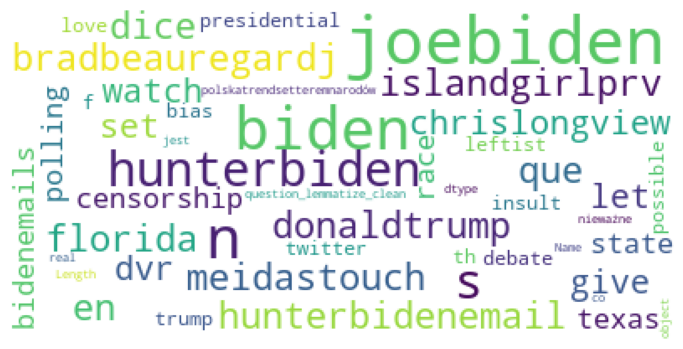

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

C:\Users\Darkwolf\AppData\Roaming\Python\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' 

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,good,lock,freedom,lady,president,crowd,wtf,adviser,class,nytime,censor,official,crackpipebiden,understand,police,cover,burisma,use,bidengate,aca
Topic 1,joebiden,biden,que,love,florida,year,dem,por,guilty,america,wisconsin,foxnew,sobre,donaldtrump,httpstcokhrzuhsrqi,ohio,follow,michigan,cover,nytimes
Topic 2,day,plan,stand,let,cocaine,mind,joebiden,make,lead,president,involve,future,impeach,inspire,donation,far,rudygiuliani,people,light,election
Topic 3,biden,trump,nbc,watch,bidentownhall,boycottnbc,time,abc,joebiden,rating,let,amp,hall,town,know,townhall,thursday,boycott,tonight,hey
Topic 4,obama,blm,blacklivesmatter,biden,begin,trump,bad,kamalaharris,aoc,votere,hunterbidden,riots,kamalaharrisvp,mikepence,tedwheeler,gretchenwhitmer,gavinnewsom,gtgt,going,ilhanomar
Topic 5,biden,new,post,trump,york,las,voting,negative,campa,elecciones,ear,ganar,para,probably,sus,lock,vice,president,account,close
Topic 6,ukrainegate,step,crap,rudygiuliani,suppress,act,pay,information,attempt,biden,joebiden,article,joe,censorship,facebook,nypost,amp,twitter,hold,prosecutor
Topic 7,college,happen,increase,continue,pandemic,student,seanhannity,run,resist,state,kamalaharris,regulatesiliconvalley,cheat,man,powerful,ccp,foxnews,racist,send,votebidenharris
Topic 8,bidenharristosaveamerica,biden,child,joebiden,joe,trump,donaldtrump,day,really,thing,bidenharris,week,hope,votebiden,event,racist,request,ilhanomar,federal,shokin
Topic 9,biden,hunter,joebiden,trump,hunterbiden,joe,email,big,twitter,win,ukrainian,introduce,hunterbidenemail,ukraine,american,nypost,dad,china,people,need


In [98]:
#for creating pyLDAvis Visualizations
import re, nltk, spacy, string

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
import numpy as np
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

import spacy

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

df = pd.read_csv('hashtag_joebiden.csv')
print('We have',len(df), 'questions in the data')
da = df.tweet.head(1000).astype(str)
print(da)
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df_clean = pd.DataFrame(da.apply(lambda x: clean_text(x)))

nlp = spacy.load("en_core_web_sm")
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)
    
df_clean["question_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['tweet']), axis=1)
df_clean['question_lemmatize_clean'] = df_clean['question_lemmatize'].str.replace('-PRON-', '')



mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['question_lemmatize_clean']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words='english',             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000,          
                            )

data_vectorized = vectorizer.fit_transform(df_clean['question_lemmatize_clean'])

lda_model = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer)


def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords


In [99]:
#for creating pyLDAvis Visualizations
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

C:\Users\Darkwolf\AppData\Roaming\Python\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.155559 -0.131771       1        1  27.870135
9     -0.122751 -0.051938       2        1  20.121313
13    -0.079047 -0.187933       3        1   8.646189
3     -0.188422  0.058707       4        1   7.738097
12    -0.113275  0.211788       5        1   6.377395
16    -0.178631  0.030568       6        1   5.599072
10    -0.063611 -0.112704       7        1   4.146615
1     -0.056087 -0.033967       8        1   4.101664
18     0.109971 -0.196083       9        1   2.598477
4     -0.050253  0.140706      10        1   2.581071
19    -0.027623 -0.036785      11        1   2.412682
5     -0.083881  0.119224      12        1   1.970322
17     0.104762 -0.040631      13        1   1.151478
11     0.175190  0.053421      14        1   1.000952
2      0.110825  0.030472      15        1   0.903792
6      0.157299  0.032349      16        1   0.758024
7      0.142575  0.043812      17        1   0.628291
8      0.105656  0.023671      18        1   0.464811
14     0.106413  0.023593      19        1   0.464811
0      0.106449  0.023500      20        1   0.464811, topic_info=                 Term        Freq       Total Category  logprob  loglift
364          joebiden  541.000000  541.000000  Default  30.0000  30.0000
56              biden  627.000000  627.000000  Default  29.0000  29.0000
327  hunterbidenemail   77.000000   77.000000  Default  28.0000  28.0000
690             trump  210.000000  210.000000  Default  27.0000  27.0000
727              vote  114.000000  114.000000  Default  26.0000  26.0000
..                ...         ...         ...      ...      ...      ...
293              hack    0.055608    7.686514  Topic20  -6.6432   0.4424
236          facebook    0.055606   56.139244  Topic20  -6.6433  -1.5460
239           fakenew    0.055603    7.037377  Topic20  -6.6433   0.5306
83         boycottnbc    0.055602   27.284469  Topic20  -6.6433  -0.8246
457              news    0.055596   19.293290  Topic20  -6.6435  -0.4781

[1037 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         4  0.955439         abc
1         7  0.824562     ability
2         8  0.712940         aca
3         5  0.937198  acbhearing
4         2  0.591577      accord
...     ...       ...         ...
769      12  0.798166        york
770       1  0.472868       young
770       5  0.236434       young
770       8  0.236434       young
771       2  0.946483     youtube

[1053 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 10, 14, 4, 13, 17, 11, 2, 19, 5, 20, 6, 18, 12, 3, 7, 8, 9, 15, 1])